In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tqdm
import matplotlib.cm
import tensorflow as tf
import collections
from scipy.special import softmax

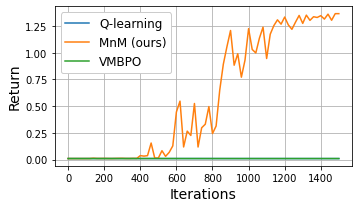

In [21]:
### Fig 2a (left): Stochastic gridworld

noise = 0.5  # Probably of a random action
size = 10  # 20
num_states = size**2
num_actions = 4
gamma = 0.9

def ij_to_index(i, j):
  return i * size + j

def index_to_ij(index):
  return (index // size, index % size)


WALLS = np.zeros((size, size))
WALLS[0:6, 4:6] = 1

A_DELTA = np.array([
                    [-1, 0],
                    [0, 1],
                    [1, 0],
                    [0, -1]
                    ])
def dynamics(index, a):
  i, j = index_to_ij(index)
  (i, j) = (i, j) + A_DELTA[a]
  (i, j) = np.clip((i, j), 0, size - 1)
  if WALLS[i, j]:
    i, j = index_to_ij(index)
  index2 = ij_to_index(i, j)
  return index2

p_s_given_sa = np.zeros([num_states, num_actions, num_states])
for index, a in itertools.product(range(num_states), range(num_actions)):
  for a2 in range(num_actions):
    index2 = dynamics(index, a2)
    p_s_given_sa[index, a, index2] += noise / num_actions
  index2 = dynamics(index, a)
  p_s_given_sa[index, a, index2] += (1 - noise)

# define the reward function
r_sa = np.zeros([num_states, num_actions]) + 0.001
goal_i, goal_j = (0, size - 1)
index = ij_to_index(goal_i, goal_j)
r_sa[index] = 10.0  # Sparse reward for reaching the goal state


# implement value iteration
def value_iteration(p_s_given_sa, pi_a_given_s, r_sa):
  Q = np.zeros([num_states, num_actions])
  for t in range(1000):
    V = np.einsum('ij,ij->i', pi_a_given_s, Q)
    V_next = np.einsum('ijk,k->ij', p_s_given_sa, V)
    Q_new = r_sa + gamma * V_next
    diff = np.linalg.norm(Q - Q_new, ord=np.inf)
    if diff < 1e-6:
      # print('Value iteration converged in %d iterations' % t)
      break
    Q = Q_new.copy()
  return Q

def plot_dynamics2(q_s_given_sa):
  plt.figure(figsize=(8, 8))
  plt.imshow(WALLS, cmap='Greys', extent=(0, size, 0, size), alpha=0.5, origin='lower')
  for index, a in itertools.product(range(num_states), range(num_actions)):
    index2 = dynamics(index, a)
    p = q_s_given_sa[index, a, index2]
    i, j = index_to_ij(index)
    if not WALLS[i, j]:
      di, dj = 0.4 * p * A_DELTA[a]
      c = matplotlib.cm.Blues(p)
      plt.arrow(j + 0.5, i + 0.5, dj, di, length_includes_head=False, width=0.03,
                fc=c, ec=c)
  plt.grid()
  plt.plot([goal_j + 0.5], [goal_i + 0.5], 'g*', ms=50)
  plt.xlim([0, size])
  plt.ylim([size, 0])
  plt.show()

def get_traj(p_s_given_sa, pi_a_given_s, r_sa, max_episode_steps):
  s = ij_to_index(0, 0)  # np.random.randint(0, 4))
  # i_vec, j_vec = np.where(WALLS == 0)
  # index = np.random.choice(len(i_vec))
  # s = ij_to_index(i_vec[index], j_vec[index])
  s_vec = []
  a_vec = []
  ns_vec = []
  r_vec = []
  for _ in range(max_episode_steps):
    a = np.random.choice(num_actions, p=pi_a_given_s[s])
    ns = np.random.choice(num_states, p=p_s_given_sa[s, a])
    r = r_sa[s, a]  # Should this depend on the next state?
    s_vec.append(s)
    a_vec.append(a)
    ns_vec.append(ns)
    r_vec.append(r)
    s = ns
  return np.array(s_vec), np.array(a_vec), np.array(r_vec), np.array(ns_vec)

max_episode_steps = 200
learning_rate = 1e-2
epsilon = 0.5

def mnm(num_iter=200, include_classifier=True, include_log=True, use_learned_dynamics=True):
  pi_a_given_s = np.ones([num_states, num_actions]) / num_actions
  Q = np.zeros([num_states, num_actions])

  value_vec = []
  s_vec_vec = []
  a_vec_vec = []
  r_vec_vec = []
  ns_vec_vec = []
  error_vec = []
  q_vec = []
  for t in tqdm.trange(num_iter):
    V = np.max(Q, axis=-1)
    q_s_given_sa = p_s_given_sa * np.exp(V)
    q_s_given_sa = q_s_given_sa / q_s_given_sa.sum(-1)[:, :, None]

    kl = np.nansum(q_s_given_sa * (np.log(q_s_given_sa) - np.log(p_s_given_sa)), axis=-1)
    r_sa_aug = (1 - gamma) * np.log(r_sa) if include_log else r_sa.copy()
    if include_classifier:
      r_sa_aug -= kl
    if use_learned_dynamics:
      s_vec, a_vec, r_vec, ns_vec = get_traj(q_s_given_sa, pi_a_given_s, r_sa_aug, max_episode_steps)
    else:
      s_vec, a_vec, r_vec, ns_vec = get_traj(p_s_given_sa, pi_a_given_s, r_sa_aug, max_episode_steps)

    s_vec_vec = np.concatenate([s_vec_vec, s_vec]).astype(np.int64)
    a_vec_vec = np.concatenate([a_vec_vec, a_vec]).astype(np.int64)
    r_vec_vec = np.concatenate([r_vec_vec, r_vec])
    ns_vec_vec = np.concatenate([ns_vec_vec, ns_vec]).astype(np.int64)    

    td_target = r_vec_vec + gamma * V[ns_vec_vec]
    np.add.at(Q, (s_vec_vec, a_vec_vec), learning_rate * (td_target - Q[s_vec_vec, a_vec_vec]) / max_episode_steps)
    error_vec.append(np.mean((td_target - Q[s_vec_vec, a_vec_vec])**2))
    pi_a_given_s_new = np.ones([num_states, num_actions]) * epsilon / num_actions
    pi_a_given_s_new[np.arange(num_states), np.argmax(Q, axis=1)] += (1 - epsilon)
    pi_a_given_s = pi_a_given_s_new.copy()
    q_vec.append(np.mean(td_target))

    # value_vec.append(np.mean(td_target))

    if t % 20 == 0:
      pi_a_given_s_eval = np.zeros([num_states, num_actions])
      pi_a_given_s_eval[np.arange(num_states), np.argmax(Q, axis=1)] = 1
      # value of policy on real dynamics w/ real reward
      Q_exact = value_iteration(p_s_given_sa, pi_a_given_s_eval, r_sa)
      V_exact = np.einsum('ij,ij->i', pi_a_given_s_eval, Q_exact)
      start_i, start_j = 0, 0
      start_index = ij_to_index(start_i, start_j)
      value = V_exact[start_index]
      value_vec.append(value)

  value_vec = np.array(value_vec)
  return value_vec, pi_a_given_s_eval, q_vec

method_vec = []
data_vec = []
c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']
for method, include_classifier, include_log, use_learned_dynamics, c in [
                                                                         ('Q_learning', False, False, False, c_vec[0]),
                                                                      ('MnM', True, True, True, c_vec[1]),
                                                                      ('VMBPO ', True, False, True, c_vec[2]),
                                                                      ]:
  vec = []
  for index in range(1):  # Fig. 2a (left) uses 5 seeds
    value_vec, pi_a_given_s, q_vec = mnm(num_iter=1501,
                                         include_classifier=include_classifier,
                    include_log=include_log, use_learned_dynamics=use_learned_dynamics)
    vec.append(value_vec.astype(np.float32).tolist())
  method_vec.append(method)
  data_vec.append(vec)

plt.figure(figsize=(5, 3.))
plt.gcf().set_size_inches(5, 3.)
for c, method, vec in zip(c_vec, method_vec, data_vec):
  vec = np.array(vec)
  if method == 'Q_learning':
    label = 'Q-learning'
  elif method == 'MnM':
    label = 'MnM (ours)'
  else:
    assert method == 'VMBPO '
    label = 'VMBPO'
  for index, y in enumerate(vec):
    t = 20 * np.arange(len(y))
    plt.plot(t, y, c=c, label=label if index == 0 else None)
plt.grid()
plt.legend(fontsize=12, framealpha=1)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.tight_layout()
filename = 'fig_2a_left.png'
with tf.compat.v1.gfile.Open(filename, 'wb') as f:
  plt.savefig(f, dpi=300, bbox_inches='tight')
plt.show()

0.857286543175779
0.002676412798026717
4.242812147170483e-06
VMBPO iteration converged in 23 iterations


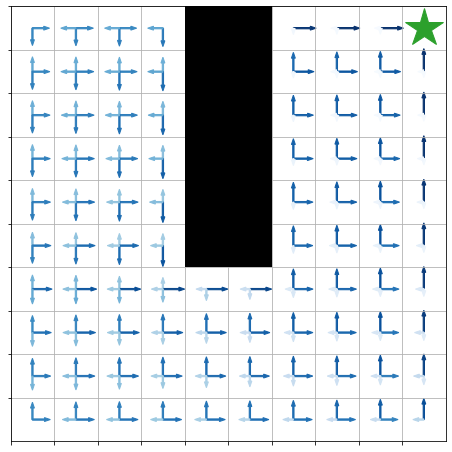

In [8]:
### Fig 2a (right): visualizing the optimistic dynamics

noise = 0.5  # Probably of a random action
size = 10  # 20
num_states = size**2
num_actions = 4
gamma = 0.9

def ij_to_index(i, j):
  return i * size + j

def index_to_ij(index):
  return (index // size, index % size)

WALLS = np.zeros((size, size))
WALLS[0:6, 4:6] = 1

A_DELTA = np.array([
                    [-1, 0],
                    [0, 1],
                    [1, 0],
                    [0, -1]
                    ])
def dynamics(index, a):
  i, j = index_to_ij(index)
  (i, j) = (i, j) + A_DELTA[a]
  (i, j) = np.clip((i, j), 0, size - 1)
  if WALLS[i, j]:
    i, j = index_to_ij(index)
  index2 = ij_to_index(i, j)
  return index2

# standard dynamics
p_s_given_sa = np.zeros([num_states, num_actions, num_states])  # [s_t, a_t, s_{t+1}]
for index, a in itertools.product(range(num_states), range(num_actions)):
  i, j = index_to_ij(index)
  for a2 in range(num_actions):
    index2 = dynamics(index, a2)
    p_s_given_sa[index, a, index2] += noise / num_actions
  index2 = dynamics(index, a)
  p_s_given_sa[index, a, index2] += (1 - noise)

goal_i, goal_j = (0, size - 1)
start_i, start_j = (0, 0)
index = ij_to_index(goal_i, goal_j)
r_sa = np.zeros([num_states, num_actions]) + 1e-5
r_sa[index] = 1e9

# implement value iteration
def value_iteration(p_s_given_sa, pi_a_given_s, r_sa):
  Q = np.zeros([num_states, num_actions])
  for t in range(1000):
    V = np.einsum('ij,ij->i', pi_a_given_s, Q)
    V_next = np.einsum('ijk,k->ij', p_s_given_sa, V)
    Q_new = r_sa + gamma * V_next
    diff = np.linalg.norm(Q - Q_new, ord=np.inf)
    if diff < 1e-6:
      # print('Value iteration converged in %d iterations' % t)
      break
    Q = Q_new.copy()
  return Q

def plot_dynamics2(q_s_given_sa, filename=None):
  plt.figure(figsize=(8, 8))
  img = np.tile((1 - WALLS)[:, :, None], [1, 1, 4])
  img[:, :, :3] *= 255
  img[:, :, 3] = (1 - img[:, :, 3])
  plt.imshow(img, extent=(0, size, 0, size), origin='lower', zorder=10)
  for index, a in itertools.product(range(num_states), range(num_actions)):
    index2 = dynamics(index, a)
    i2, j2 = index_to_ij(index2)
    p = q_s_given_sa[index, a, index2]
    i, j = index_to_ij(index)
    if not WALLS[i, j] and index != index2:
      di, dj = 0.4 * p * A_DELTA[a]
      c = matplotlib.cm.Blues(p)
      plt.arrow(j + 0.5, i + 0.5, dj, di, length_includes_head=False, width=0.03,
                fc=c, ec=c)
  plt.grid()
  plt.xticks(np.arange(size))
  plt.yticks(np.arange(size))
  plt.gca().xaxis.set_ticklabels([])
  plt.gca().yaxis.set_ticklabels([])
  c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']
  plt.plot([goal_j + 0.5], [goal_i + 0.5], '*', c=c_vec[2], ms=40)
  plt.xlim([0, size])
  plt.ylim([size, 0])
  if filename is not None:
    with tf.compat.v1.gfile.Open(filename, 'wb') as f:
      plt.savefig(f, dpi=300, bbox_inches='tight')
  plt.show()

# define the initial random policy
pi_a_given_s = np.ones([num_states, num_actions]) / num_actions
q_s_given_sa = p_s_given_sa.copy()
value_vec = []
for t in range(100):
  kl = np.nansum(q_s_given_sa * (np.log(q_s_given_sa) - np.log(p_s_given_sa)), axis=-1)
  Q = value_iteration(q_s_given_sa, pi_a_given_s, (1 - gamma) * np.log(r_sa) - kl - (1 - gamma) * np.log(1 - gamma))
  pi_a_given_s_new = np.zeros([num_states, num_actions])
  pi_a_given_s_new[np.arange(num_states), np.argmax(Q, axis=1)] = 1
    
  V = np.einsum('ij,ij->i', pi_a_given_s_new, Q)
  q_s_given_sa_new = np.einsum('ijk,k->ijk', p_s_given_sa, np.exp(V))
  q_s_given_sa_new = q_s_given_sa_new / q_s_given_sa_new.sum(-1)[:, :, None]

  diff = np.max(np.abs(q_s_given_sa - q_s_given_sa_new))

  if t % 10 == 0:
    print(diff)
  if diff < 1e-6:
    print('VMBPO iteration converged in %d iterations' % t)
    break
  tau = 0.5  # Any value >= 0.2 seems to work. In effect, we're solving a
            # two-player game. It's well known that ``best response'' style
            # methods can fail to converge, but adding some smoothing allows
            # for convergence.
  q_s_given_sa = (1 - tau) * q_s_given_sa_new.copy() + tau * q_s_given_sa
  pi_a_given_s = (1 - tau) * pi_a_given_s_new.copy() + tau * pi_a_given_s

plot_dynamics2(q_s_given_sa, filename='fig_2a_right.png')

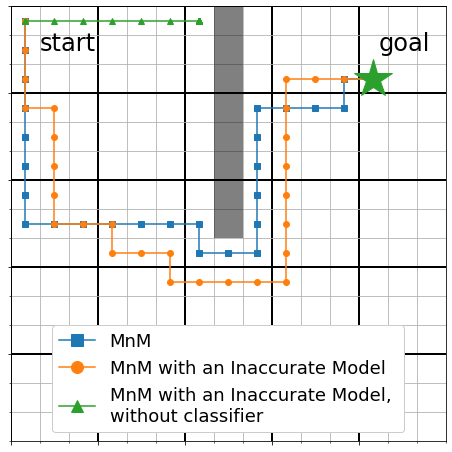

In [20]:
### Fig 2b: Inaccurate models

noise = 0.0  # Probably of a random action
size = 15  # 20
num_states = size**2
num_actions = 5
gamma = 0.9

def ij_to_index(i, j):
  return i * size + j

def index_to_ij(index):
  return (index // size, index % size)

WALLS = np.zeros((size, size))
WALLS[:8, 7] = 1

A_DELTA = np.array([
                    [-1, 0],
                    [0, 1],
                    [1, 0],
                    [0, -1],
                    [0, 0],
                    ])
def dynamics(index, a):
  i, j = index_to_ij(index)
  (i, j) = (i, j) + A_DELTA[a]
  (i, j) = np.clip((i, j), 0, size - 1)
  if WALLS[i, j]:
    i, j = index_to_ij(index)
  index2 = ij_to_index(i, j)
  return index2

# standard dynamics
p_s_given_sa = np.zeros([num_states, num_actions, num_states])  # [s_t, a_t, s_{t+1}]
for index, a in itertools.product(range(num_states), range(num_actions)):
  i, j = index_to_ij(index)
  for a2 in range(num_actions):
    index2 = dynamics(index, a2)
    p_s_given_sa[index, a, index2] += noise / num_actions
  index2 = dynamics(index, a)
  p_s_given_sa[index, a, index2] += (1 - noise)

goal_i, goal_j = (2, size - 3)
# start_i, start_j = (2, 2)
start_i, start_j = (0, 0)
index = ij_to_index(goal_i, goal_j)
r_sa = np.zeros([num_states, num_actions]) + 1.0
r_sa[index] = 100.0

# implement value iteration
def value_iteration(p_s_given_sa, pi_a_given_s, r_sa):
  Q = np.zeros([num_states, num_actions])
  for t in range(1000):
    V = np.einsum('ij,ij->i', pi_a_given_s, Q)
    V_next = np.einsum('ijk,k->ij', p_s_given_sa, V)
    Q_new = r_sa + gamma * V_next
    diff = np.linalg.norm(Q - Q_new, ord=np.inf)
    if diff < 1e-6:
      # print('Value iteration converged in %d iterations' % t)
      break
    Q = Q_new.copy()
  return Q

def block_average(p_s_given_sa):
  block_size = 3
  new_p_s_given_sa = np.zeros_like(p_s_given_sa)
  # for each macroblock
  for block_i, block_j, a in itertools.product(range(size//block_size), range(size//block_size), range(num_actions)):
    delta_dict = collections.defaultdict(float)
    for i, j in itertools.product(range(block_size*block_i, block_size*(block_i+1)), range(block_size*block_j, block_size*(block_j+1))):
      index = ij_to_index(i, j)
      for index2, p in enumerate(p_s_given_sa[index, a]):
        if p == 0: continue
        i2, j2 = index_to_ij(index2)
        di = i2 - i
        dj = j2 - j
        delta_dict[(di, dj)] += p / (block_size**2)
    for i, j in itertools.product(range(block_size*block_i, block_size*(block_i+1)), range(block_size*block_j, block_size*(block_j+1))):
      index = ij_to_index(i, j)
      for (di, dj), p in delta_dict.items():
        i2 = np.clip(i + di, 0, size - 1)
        j2 = np.clip(j + dj, 0, size - 1)
        index2 = ij_to_index(i2, j2)
        new_p_s_given_sa[index, a, index2] += p
  return new_p_s_given_sa

def get_traj(p_s_given_sa, pi_a_given_s, r_sa, max_episode_steps):
  s = ij_to_index(start_i, start_j)
  s_vec = [s]
  a_vec = []
  ns_vec = []
  r_vec = []
  for _ in range(max_episode_steps):
    a = np.random.choice(num_actions, p=pi_a_given_s[s])
    ns = np.random.choice(num_states, p=p_s_given_sa[s, a])
    r = r_sa[s, a]  # Should this depend on the next state?
    s_vec.append(s)
    a_vec.append(a)
    ns_vec.append(ns)
    r_vec.append(r)
    s = ns
  return np.array(s_vec), np.array(a_vec), np.array(r_vec), np.array(ns_vec)

def get_policy(include_classifier, use_aliasing):
  p_block_s_given_sa = block_average(p_s_given_sa)
  pi_a_given_s = np.ones([num_states, num_actions]) / num_actions
  q_s_given_sa = p_s_given_sa.copy()
  value_vec = []
  for t in tqdm.trange(20):
    kl = np.nansum(q_s_given_sa * (np.log(q_s_given_sa) - np.log(p_s_given_sa)), axis=-1)
    kl = np.clip(kl, 0, 5)  # Corresponds to label smoothing with C/(1 - C) with parameter 0.7

    r = (1 - gamma) * np.log(r_sa)
    if include_classifier:
      r = r - kl
    Q = value_iteration(q_s_given_sa, pi_a_given_s, r)
    pi_a_given_s_new = np.zeros([num_states, num_actions])
    pi_a_given_s_new[np.arange(num_states), np.argmax(Q, axis=1)] = 1
      
    tau = 0.5  # Any value >= 0.2 seems to work. In effect, we're solving a
              # two-player game. It's well known that ``best response'' style
              # methods can fail to converge, but adding some smoothing allows
              # for convergence.
    pi_a_given_s = (1 - tau) * pi_a_given_s_new.copy() + tau * pi_a_given_s
    V = np.einsum('ij,ij->i', pi_a_given_s_new, Q)
    assert np.all(np.isfinite(V))
    q_s_given_sa_new = np.einsum('ijk,k->ijk', p_block_s_given_sa if use_aliasing else p_s_given_sa,
                                  np.exp(V))
    q_s_given_sa_new = q_s_given_sa_new / q_s_given_sa_new.sum(-1)[:, :, None]
    q_s_given_sa = (1 - tau) * q_s_given_sa_new.copy() + tau * q_s_given_sa
    if use_aliasing:
      q_s_given_sa = block_average(q_s_given_sa)
    assert np.all(np.isfinite(q_s_given_sa))
      
  return pi_a_given_s

plt.figure(figsize=(8, 8))
c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']

### MnM
pi_a_given_s = get_policy(include_classifier=True, use_aliasing=False)
s_vec, _, _, _ = get_traj(p_s_given_sa, pi_a_given_s, r_sa, max_episode_steps=100)
ij_vec = np.array([index_to_ij(index) for index in s_vec])
plt.plot(ij_vec[:, 1] + 0.5, ij_vec[:, 0] + 0.5, marker='s', label='MnM', c=c_vec[0])

### MnM + inaccurate model
pi_a_given_s = get_policy(include_classifier=True, use_aliasing=True)
s_vec, _, _, _ = get_traj(p_s_given_sa, pi_a_given_s, r_sa, max_episode_steps=100)
ij_vec = np.array([index_to_ij(index) for index in s_vec])
plt.plot(ij_vec[:, 1] + 0.5, ij_vec[:, 0] + 0.5, marker='o',
          label='MnM with an Inaccurate Model', c=c_vec[1])

### MnM with an Inaccurate Model, without classifier
pi_a_given_s = get_policy(include_classifier=False, use_aliasing=True)
s_vec, _, _, _ = get_traj(p_s_given_sa, pi_a_given_s, r_sa, max_episode_steps=100)
ij_vec = np.array([index_to_ij(index) for index in s_vec])
plt.plot(ij_vec[:, 1] + 0.5, ij_vec[:, 0] + 0.5, marker='^',
          label='MnM with an Inaccurate Model, \nwithout classifier', c=c_vec[2])

img = np.tile((1 - WALLS)[:, :, None], [1, 1, 4])
img[:, :, :3] *= 255
img[:, :, 3] = 0.5 * (1 - img[:, :, 3])
plt.imshow(img, extent=(0, size, 0, size), origin='lower', zorder=10)
plt.xticks(np.arange(size // 3) * 3)
plt.yticks(np.arange(size // 3) * 3)
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.grid(which='minor')
plt.grid(which='major', linewidth=2, c='k')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.plot([goal_j + 0.5], [goal_i + 0.5], '*', c=c_vec[2], ms=40)
plt.xlim([0, size])
plt.ylim([size, 0])
leg = plt.legend(fontsize=18, framealpha=1, loc='lower center')
for handle in leg.legendHandles:
  handle._legmarker.set_markersize(12)
plt.text(12.7, 1.5, 'goal', fontsize=24)
plt.text(1, 1.5, 'start', fontsize=24)


filename = 'fig_2b.png'
with tf.compat.v1.gfile.Open(filename, 'wb') as f:
  plt.savefig(f, dpi=300, bbox_inches='tight')
plt.show()

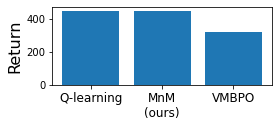

In [9]:
### Fig 3a (left): Testing for risk seeing behavior

noise = 0.5  # Probably of a random action
size = 3  # 20
num_states = size**2
num_actions = 4
gamma = 0.9

def ij_to_index(i, j):
  return i * size + j

def index_to_ij(index):
  return (index // size, index % size)

WALLS = np.zeros((size, size))
WALLS[1:] = 1

A_DELTA = np.array([
                    [-1, 0],
                    [0, 1],
                    [1, 0],
                    [0, -1]
                    ])
def dynamics(index, a):
  i, j = index_to_ij(index)
  (i, j) = (i, j) + A_DELTA[a]
  (i, j) = np.clip((i, j), 0, size - 1)
  if WALLS[i, j]:
    i, j = index_to_ij(index)
  index2 = ij_to_index(i, j)
  return index2

# line dynamics
p_s_given_sa = np.zeros([num_states, num_actions, num_states])  # [s_t, a_t, s_{t+1}]
for i in range(size):
  for j, a in itertools.product([0, 1], range(num_actions)):
    index = ij_to_index(i, j)
    index2 = dynamics(index, a)
    p_s_given_sa[index, a, index2] = 1
  j = 2
  index = ij_to_index(i, j)
  noise = 0.5
  for a in range(num_actions):
    index2 = dynamics(index, a)
    p_s_given_sa[index, a, index2] += (1 - noise)

    index2 = dynamics(index, a=3)
    p_s_given_sa[index, a, index2] += noise

r_sa = np.zeros([num_states, num_actions]) + 1.0
for i in range(size):
  index = ij_to_index(i=i, j=0)
  r_sa[index] = 50.0

  index = ij_to_index(i=i, j=2)
  r_sa[index] = 51.0

# implement value iteration
def value_iteration(p_s_given_sa, pi_a_given_s, r_sa):
  Q = np.zeros([num_states, num_actions])
  for t in range(1000):
    V = np.einsum('ij,ij->i', pi_a_given_s, Q)
    V_next = np.einsum('ijk,k->ij', p_s_given_sa, V)
    Q_new = r_sa + gamma * V_next
    diff = np.linalg.norm(Q - Q_new, ord=np.inf)
    if diff < 1e-6:
      # print('Value iteration converged in %d iterations' % t)
      break
    Q = Q_new.copy()
  return Q

def get_policy(include_classifier, include_log, use_learned_dynamics):
  # define the initial random policy
  pi_a_given_s = np.ones([num_states, num_actions]) / num_actions
  q_s_given_sa = p_s_given_sa.copy()
  value_vec = []
  for t in range(100):
    kl = np.nansum(q_s_given_sa * (np.log(q_s_given_sa) - np.log(p_s_given_sa)), axis=-1)
    r = (1 - gamma) * np.log(r_sa) if include_log else r_sa
    if include_classifier:
      r = r - kl
    Q = value_iteration(q_s_given_sa if use_learned_dynamics else p_s_given_sa,
                        pi_a_given_s, r)
    pi_a_given_s_new = np.zeros([num_states, num_actions])
    pi_a_given_s_new[np.arange(num_states), np.argmax(Q, axis=1)] = 1
      
    V = np.einsum('ij,ij->i', pi_a_given_s_new, Q)
    # Subtract the mean for numerical stability. This is just a constant, which doesn't matter because we normalize on the next line
    q_s_given_sa_new = np.einsum('ijk,k->ijk', p_s_given_sa, np.exp(V - np.mean(V)))
    q_s_given_sa_new = q_s_given_sa_new / q_s_given_sa_new.sum(-1)[:, :, None]

    diff = np.max(np.abs(q_s_given_sa - q_s_given_sa_new))

    if diff < 1e-6:
      break
    tau = 0.5  # Any value >= 0.2 seems to work. In effect, we're solving a
              # two-player game. It's well known that ``best response'' style
              # methods can fail to converge, but adding some smoothing allows
              # for convergence.
    q_s_given_sa = (1 - tau) * q_s_given_sa_new.copy() + tau * q_s_given_sa
    pi_a_given_s = (1 - tau) * pi_a_given_s_new.copy() + tau * pi_a_given_s
  
  Q = value_iteration(p_s_given_sa, pi_a_given_s, r_sa)
  V = np.einsum('ij,ij->i', pi_a_given_s_new, Q)
  start_i, start_j = (0, 1)
  index = ij_to_index(start_i, start_j)
  value = V[index]
  return value

label_vec = []
y_vec = []
for method, include_classifier, include_log, use_learned_dynamics in [('Q-learning', False, False, False),
                                                                      ('MnM (ours)', True, True, True),
                                                                      ('VMBPO ', True, False, True)]:
  value = get_policy(include_classifier=include_classifier,
                            include_log=include_log,
                            use_learned_dynamics=use_learned_dynamics)
  label_vec.append(method)
  y_vec.append(value)

plt.plot(figsize=(10, 1))
plt.gcf().set_size_inches(4, 1.8)
x = np.arange(3)
plt.bar(x, y_vec)
plt.xticks(x, ['Q-learning', 'MnM\n(ours)', 'VMBPO'], fontsize=12)
plt.ylabel('Return', fontsize=16)
plt.tight_layout()
filename = 'fig_3a.png'
with tf.compat.v1.gfile.Open(filename, 'wb') as f:
  plt.savefig(f, dpi=300, bbox_inches='tight')
plt.show()

0.09792465318061616
0.00027014772344491345
VMBPO iteration converged in 19 iterations


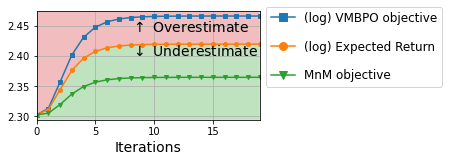

In [6]:
### Fig 3b: measuring the lower bound

noise = 0.5  # Probably of a random action
size = 10  # 20
num_states = size**2
num_actions = 4
gamma = 0.9

def ij_to_index(i, j):
  return i * size + j

def index_to_ij(index):
  return (index // size, index % size)


WALLS = np.zeros((size, size))
WALLS[0:6, 4:6] = 1

A_DELTA = np.array([
                    [-1, 0],
                    [0, 1],
                    [1, 0],
                    [0, -1]
                    ])
def dynamics(index, a):
  i, j = index_to_ij(index)
  (i, j) = (i, j) + A_DELTA[a]
  (i, j) = np.clip((i, j), 0, size - 1)
  if WALLS[i, j]:
    i, j = index_to_ij(index)
  index2 = ij_to_index(i, j)
  return index2

p_s_given_sa = np.zeros([num_states, num_actions, num_states])
for index, a in itertools.product(range(num_states), range(num_actions)):
  for a2 in range(num_actions):
    index2 = dynamics(index, a2)
    p_s_given_sa[index, a, index2] += noise / num_actions
  index2 = dynamics(index, a)
  p_s_given_sa[index, a, index2] += (1 - noise)

# define the reward function
r_sa = np.zeros([num_states, num_actions]) + 1.0
start_i, start_j = (0, 0)
goal_i, goal_j = (0, size - 1)
index = ij_to_index(goal_i, goal_j)
r_sa[index] = 10.0  # Sparse reward for reaching the goal state

# implement value iteration
def value_iteration(p_s_given_sa, pi_a_given_s, r_sa):
  Q = np.zeros([num_states, num_actions])
  for t in range(1000):
    V = np.einsum('ij,ij->i', pi_a_given_s, Q)
    V_next = np.einsum('ijk,k->ij', p_s_given_sa, V)
    Q_new = r_sa + gamma * V_next
    diff = np.linalg.norm(Q - Q_new, ord=np.inf)
    if diff < 1e-6:
      # print('Value iteration converged in %d iterations' % t)
      break
    Q = Q_new.copy()
  return Q

# define the initial random policy
pi_a_given_s = np.ones([num_states, num_actions]) / num_actions
q_s_given_sa = p_s_given_sa.copy()
value_vec = []
for t in range(100):
  kl = np.nansum(q_s_given_sa * (np.log(q_s_given_sa) - np.log(p_s_given_sa)), axis=-1)
  Q = value_iteration(q_s_given_sa, pi_a_given_s, (1 - gamma) * np.log(r_sa) - kl - (1 - gamma) * np.log(1 - gamma))
  pi_a_given_s_new = np.zeros([num_states, num_actions])
  pi_a_given_s_new[np.arange(num_states), np.argmax(Q, axis=1)] = 1
    
  V = np.einsum('ij,ij->i', pi_a_given_s_new, Q)
  q_s_given_sa_new = np.einsum('ijk,k->ijk', p_s_given_sa, np.exp(V))
  q_s_given_sa_new = q_s_given_sa_new / q_s_given_sa_new.sum(-1)[:, :, None]

  diff = np.max(np.abs(q_s_given_sa - q_s_given_sa_new))

  # for evaluation
  Q = value_iteration(p_s_given_sa, pi_a_given_s, r_sa)
  V = np.einsum('ij,ij->i', pi_a_given_s_new, Q)
  index = ij_to_index(start_i, start_j)
  value_real = V[index]
  
  Q = value_iteration(q_s_given_sa, pi_a_given_s, (1 - gamma) * np.log(r_sa) - kl - (1 - gamma) * np.log(1 - gamma))
  V = np.einsum('ij,ij->i', pi_a_given_s_new, Q)
  value_lb = V[index]

  rho_sa = np.zeros((num_states, num_actions))
  index = ij_to_index(start_i, start_j)
  rho_sa[index] = pi_a_given_s[index]
  log_r_vec = []
  r_kl_vec = []
  for _ in range(300):
    log_r_vec.append(np.sum(np.log(r_sa) * rho_sa))
    r_kl_vec.append(np.sum(-kl * rho_sa))
    rho_s = np.sum(rho_sa[:, :, None] * q_s_given_sa, axis=(0, 1))
    rho_sa = rho_s[:, None] * pi_a_given_s
  log_r_vec = np.array(log_r_vec)
  r_kl_vec = np.array(r_kl_vec)
  logits = np.concatenate([[0], np.cumsum(r_kl_vec)[:-1]]) + np.arange(len(log_r_vec)) * np.log(gamma) + log_r_vec
  q_t = np.exp(logits)
  q_t /= q_t.sum()
  logits -= np.log(q_t)
  value_mnm_complex = q_t @ (logits)

  Q = value_iteration(q_s_given_sa, pi_a_given_s, r_sa)
  V = np.einsum('ij,ij->i', pi_a_given_s_new, Q)
  value_model_r = V[index]

  Q = value_iteration(q_s_given_sa, pi_a_given_s, r_sa - kl)
  V = np.einsum('ij,ij->i', pi_a_given_s_new, Q)
  value_vmbpo = V[index]

  value_vec.append((value_real, value_lb, value_mnm_complex, value_model_r, value_vmbpo))

  if t % 10 == 0:
    print(diff)
  if diff < 1e-6:
    print('VMBPO iteration converged in %d iterations' % t)
    break
  tau = 0.5  # Any value >= 0.2 seems to work. In effect, we're solving a
             # two-player game. It's well known that ``best response'' style
             # methods can fail to converge, but adding some smoothing allows
             # for convergence.
  q_s_given_sa = (1 - tau) * q_s_given_sa_new.copy() + tau * q_s_given_sa
  pi_a_given_s = (1 - tau) * pi_a_given_s_new.copy() + tau * pi_a_given_s


value_vec = np.array(value_vec)
plt.figure(figsize=(4, 2))
c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(np.log(value_vec[:, 4]), '-s', label='(log) VMBPO objective', ms=4)
plt.plot(np.log(value_vec[:, 0]), '-o', label='(log) Expected Return', ms=4)
plt.plot(value_vec[:, 2], '-v', label='MnM objective', ms=4)
plt.grid()
y_min, y_max = plt.ylim()
plt.fill_between(np.arange(len(value_vec)), np.log(value_vec[:, 0]), y_max, fc=c_vec[3], alpha=0.3)
plt.fill_between(np.arange(len(value_vec)), np.log(value_vec[:, 0]), y_min, fc=c_vec[2], alpha=0.3)
plt.ylim([y_min, y_max])
plt.xlim([0, len(value_vec) - 1])
plt.text(8, 2.44, '$\\uparrow$ Overestimate', fontsize=14)
plt.text(8, 2.40, '$\\downarrow$ Underestimate', fontsize=14)

plt.xlabel('Iterations', fontsize=14)
leg = plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(1.0, 0.25), labelspacing=1.3)
for handle in leg.legendHandles:
  handle._legmarker.set_markersize(8)

filename = 'fig_3b.png'
with tf.compat.v1.gfile.Open(filename, 'wb') as f:
  plt.savefig(f, dpi=300, bbox_inches='tight', bbox_extra_artists=(leg,))
plt.show()